In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from copy import deepcopy
from sklearn import linear_model
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats.stats import pearsonr, spearmanr, kendalltau 
from scipy import stats

from robustDA import process_cmip6, processing, anchor_regression, plots, parse_args

%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [107]:
x = np.linspace(0, 1, 100) + np.random.normal(0,0.02,100)
a = -0.5*x + np.random.normal(0,0.02,100)
noise = np.transpose(np.array([np.random.normal(0,0.05,100),
         np.random.normal(0,0.05,100),
         np.random.normal(0,0.05,100),
         np.random.normal(0,0.05,100)]))
y = np.array([1, 2, 1, 2])*x + np.array([3, 4, 3, 4])*a + noise

ValueError: operands could not be broadcast together with shapes (4,) (100,) 

In [113]:
x1 = np.arange(9.0).reshape((3, 3))

x2 = np.arange(3.0)

np.multiply(x1, x2)

array([[ 0.,  1.,  4.],
       [ 0.,  4., 10.],
       [ 0.,  7., 16.]])

In [115]:
x2

array([0., 1., 2.])

In [116]:
np.multiply(np.array([1, 2, 1, 2]), x)

ValueError: operands could not be broadcast together with shapes (4,) (100,) 

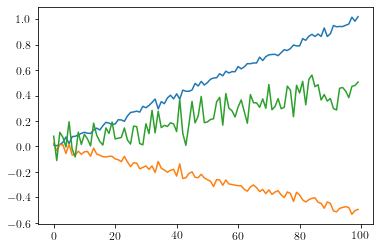

In [21]:
plt.plot(x)
plt.plot(a)
plt.plot(y);

In [62]:
ind_train = set(random.sample(range(1, 100), 50))
ind_test = set(range(1, 100)) - ind_train
x_train = np.array([x[list(ind_train)[i]] for i in range(len(ind_train))]).reshape(-1, 1)
y_train = np.array([y[list(ind_train)[i]] for i in range(len(ind_train))]).reshape(-1, 1)
a_train = np.array([a[list(ind_train)[i]] for i in range(len(ind_train))]).reshape(-1, 1)
x_test = np.array([x[list(ind_test)[i]] for i in range(len(ind_test))]).reshape(-1, 1)
y_test = np.array([y[list(ind_test)[i]] for i in range(len(ind_test))]).reshape(-1, 1)
a_test = np.array([a[list(ind_test)[i]] for i in range(len(ind_test))]).reshape(-1, 1);

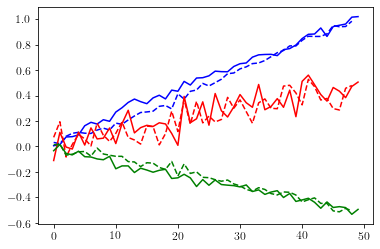

In [63]:
plt.plot(x_train, 'b')
plt.plot(x_test, 'b--')
plt.plot(y_train, 'r')
plt.plot(y_test, 'r--')
plt.plot(a_train, 'g')
plt.plot(a_test, 'g--')

In [64]:
x_train.std(axis=0)

array([0.2862274])

In [96]:
# Create a scaler object
sc_x = StandardScaler(with_mean=True, with_std=True)
sc_y = StandardScaler(with_mean=True, with_std=True)
sc_a = StandardScaler(with_mean=True, with_std=True)
sc_x_test = StandardScaler(with_mean=True, with_std=True)
sc_y_test = StandardScaler(with_mean=True, with_std=True)
sc_a_test = StandardScaler(with_mean=True, with_std=True)

# Fit the scaler to the data and transform
x_train_std = sc_x.fit_transform(x_train)
y_train_std = sc_y.fit_transform(y_train)
a_train_std = sc_a.fit_transform(a_train)
x_test_std = sc_x_test.fit_transform(x_test)
y_test_std = sc_y_test.fit_transform(y_test)
a_test_std = sc_a_test.fit_transform(a_test)

X = x_train_std
y = y_train_std
y_anchor = a_train_std
Xt = x_test_std
yt = y_test_std
yt_anchor = a_test_std

std_X_train = x_train.std(axis=0)


""" Use either the ridge implementation or direct implementation.
Ridge is usually faster and used by default.
"""

PA = anchor_regression.build_column_space(y_anchor, {})

gamma = 1000
regLambda = 0
N, p = X.shape
# "ridge":
X_PA, y_PA = anchor_regression.projection_column_space(X, y, gamma, PA)

regr = linear_model.Ridge(alpha=N * regLambda / 2)
regr.fit(X_PA, y_PA)

coefStd = regr.coef_
coefRaw = coefStd / np.array(std_X_train).reshape(1, p)

y_test_pred = regr.predict(Xt)

# "direct":
PA_C = np.identity(N) - PA

D_lambda = (
    gamma * np.mat(X.T) * PA * np.mat(X)
    + np.mat(X.T) * np.mat(PA_C) * np.mat(X)
    + N * regLambda / 2 * np.identity(p)
)

d = gamma * np.mat(X.T) * PA * np.mat(y) + np.mat(X.T) * PA_C * np.mat(
    y
)

coefStd = np.linalg.inv(D_lambda) * d
coefStd = np.asarray(coefStd.T)
coefRaw = coefStd.T / np.array(std_X_train).reshape(p, 1)

y_test_pred = np.array(np.matmul(Xt, coefStd.T))

#MSE
rmse = np.sqrt(np.mean((yt - y_test_pred) ** 2))
residuals = (yt - y_test_pred).reshape(-1)
corr_pearson = np.round(
            np.corrcoef(np.transpose(yt_anchor), np.transpose(residuals))[
                0, 1
            ],
            2,
        )

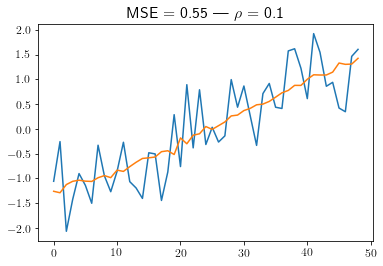

In [97]:
plt.plot(yt)
plt.plot(y_test_pred)
plt.title("MSE = " + str(np.round(rmse, 2)) + " --- $\\rho$ = " + str(np.round(corr_pearson, 2)));

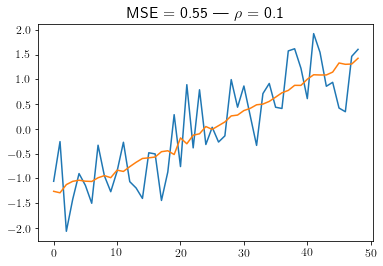

In [85]:
plt.plot(yt)
plt.plot(y_test_pred)
plt.title("MSE = " + str(np.round(rmse, 2)) + " --- $\\rho$ = " + str(np.round(corr_pearson, 2)));